# 1. Regression problem
**Goal**: predict arrival delays of flights one week in advance  

**Target variable**: `ARR_DELAY`  

**Notes:**
- 35% of the dataset has values in `ARR_DELAY`
- [Reading on linear regression](https://machinelearningmastery.com/linear-regression-for-machine-learning/)

**Steps**:
1. Pick evaluation metrics
2. Spot check different algos
3. Tune hyperparameters using grid search on 2-3 selected algos
4. Compare them based on the selected metrics

## Step 1. Pick evaluation metrics
**R Square**  
**MSE**

## Step 2. Spot check different algos (using K-Folds on sample data)

- Naive algorythm (used as a baseline model):  
Predict the average delay for all

- Linear algorythms:  
Linear Regression   
Lasso Regression  
Ridge Regression  
ElasticNet Regression  
Support Vector Machines  

- Non linear algos:  
k-Nearest Neighbors  

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting  
 *Optional: custom ensemble*

In [1]:
import numpy as np
import pandas as pd

In [2]:
# data
data = pd.read_csv('db_regression_sample.csv', index_col = 0)
print(data.shape)
print(data.columns)

data_pca = pd.read_csv('db_regression_pca_sample.csv', index_col = 0)
print(data_pca.shape)
print(data_pca.columns)

(10000, 18)
Index(['branded_code_share', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_type', 'state_travel_type', 'm_hist_dep_delay',
       'med_hist_dep_delay', 'm_hist_arr_delay', 'med_hist_arr_delay',
       'origin_cat', 'dest_cat', 'mkt_op_combo_cat', 'arr_delay'],
      dtype='object')
(1000000, 13)
Index(['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10',
       'pc11', 'pc12', 'arr_delay'],
      dtype='object')


In [5]:
y = data.arr_delay
X = data.drop('arr_delay', axis = 1)
print(y.shape)
print(X.shape)

data_pca_small = data_pca.sample(10000) ###smaller sample
y_pca_small = data_pca_small.arr_delay
X_pca_small = data_pca_small.drop('arr_delay', axis = 1)
print(y_pca_small.shape)
print(X_pca_small.shape)

y_pca = data_pca.arr_delay
X_pca = data_pca.drop('arr_delay', axis = 1)
print(y_pca.shape)
print(X_pca.shape)

(10000,)
(10000, 17)
(10000,)
(10000, 12)
(1000000,)
(1000000, 12)


In [18]:
# get a data sample with only positive delays

data_pos = data[data.arr_delay > 0]
print(data_pos.shape)
y_pos = data_pos.arr_delay
X_pos = data_pos.drop('arr_delay', axis = 1)
print(y_pos.shape)
print(X_pos.shape)

(3451, 18)
(3451,)
(3451, 17)


In [6]:
def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 12, 10
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

In [8]:
# import models to try
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# params
models = {
    'Dummy Classifier': DummyRegressor(strategy = "mean"), \
#    'KNN': KNeighborsRegressor(),  #it's really bad and impact the scale of the plot
    'Linear Regression': LinearRegression(), \
    'Lasso': Lasso(), \
    'Ridge': Ridge(), \
    'ElasticNet': ElasticNet(), \
    'Random Forest': RandomForestRegressor(), \
    'Gradient Boosting': GradientBoostingRegressor(), \
    'XGBoost': xgb.XGBRegressor(gamma=0.5, n_jobs=-1) 
#    'Polynomial Regression': make_pipeline(PolynomialFeatures(2),LinearRegression()) \  # issue with this one
    }

scoring = ('r2', 'neg_mean_squared_error')

### 10 000 datapoints sample from db_regression_sample, 5 folds (20% of data used for testing)

[23:45:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


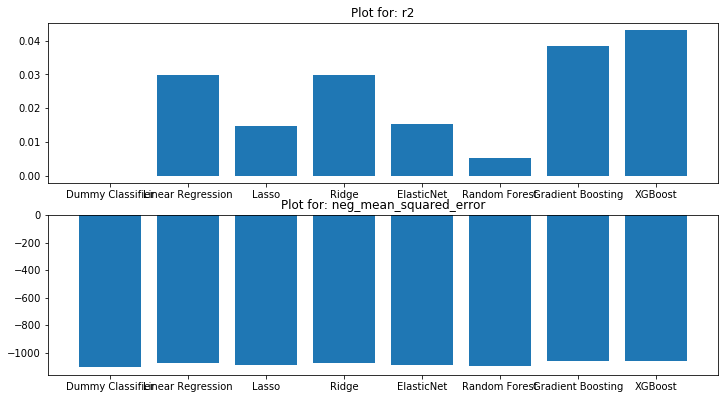

In [120]:
results_mean, results_std = perform_cross_validate(models=models, X=X, y=y, scoring=scoring, n_folds=5, plot=True)

In [121]:
results_mean

,Dummy Classifier,Linear Regression,Lasso,Ridge,ElasticNet,Random Forest,Gradient Boosting,XGBoost
r2,-0.000046,0.029906,0.014769,0.029918,0.015166,0.005091,0.038590,0.043115
neg_mean_squared_error,-1103.713324,-1070.752734,-1087.306666,-1070.737682,-1086.862809,-1097.800530,-1061.067139,-1055.961552


### 10 000 datapoints sample from db_regression_pca_sample, 5 folds (20% of data used for testing)

[00:26:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


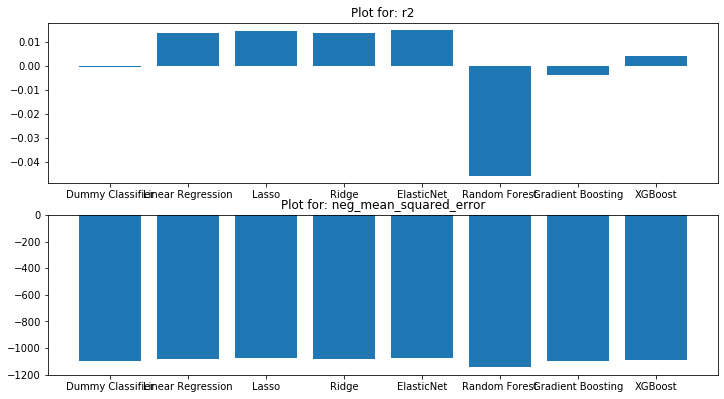

In [9]:
results_mean, results_std = perform_cross_validate(models=models, X=X_pca_small, y=y_pca_small, scoring=scoring, n_folds=5, plot=True)

In [130]:
results_mean

,Dummy Classifier,Linear Regression,Lasso,Ridge,ElasticNet,Random Forest,Gradient Boosting,XGBoost
r2,-0.000638,0.017079,0.017064,0.017079,0.017182,-0.041426,0.002005,0.009331
neg_mean_squared_error,-1043.771181,-1025.419124,-1025.491644,-1025.418517,-1025.360254,-1085.555945,-1041.370382,-1033.407602


### 1 million datapoints sample from db_regression_pca_sample, 4 folds

[04:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:28:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:28:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:29:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:29:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


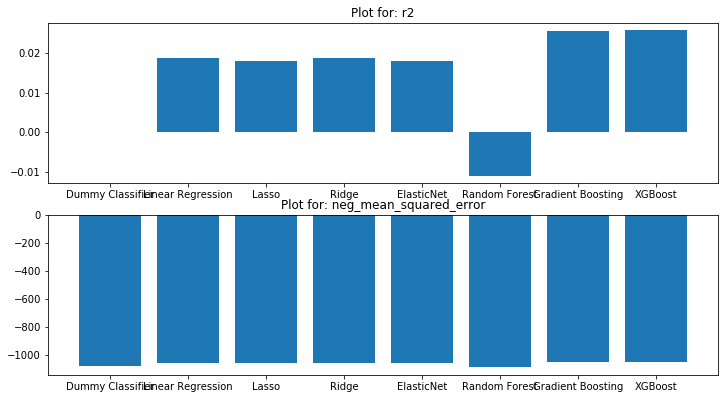

In [11]:
results_mean, results_std = perform_cross_validate(models=models, X=X_pca, y=y_pca, scoring=scoring, n_folds=5, plot=True)

In [12]:
results_mean

,Dummy Classifier,Linear Regression,Lasso,Ridge,ElasticNet,Random Forest,Gradient Boosting,XGBoost
r2,-0.000001,0.018737,0.018135,0.018737,0.018005,-0.010943,0.025684,0.025762
neg_mean_squared_error,-1078.941764,-1058.723160,-1059.373703,-1058.723160,-1059.513595,-1090.747329,-1051.228632,-1051.143559


### Only positive delay datapoints sample from db_regression_sample, 5 folds

[08:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


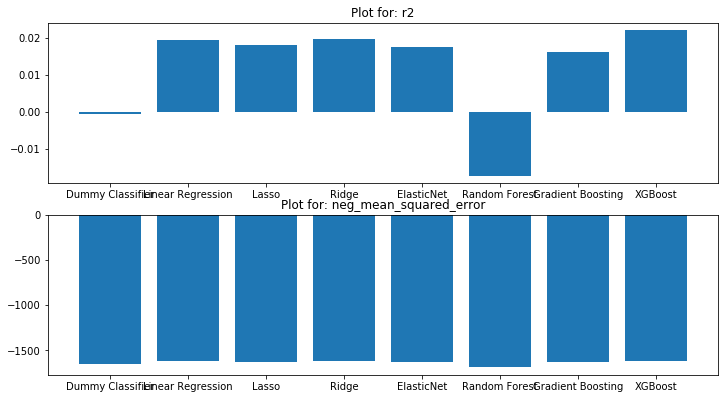

In [17]:
results_mean, results_std = perform_cross_validate(models=models, X=X_pos, y=y_pos, scoring=scoring, n_folds=5, plot=True)

Note: the MSE is negative when used in cross validation, this is done in case it's used in maximixation [source](https://www.kaggle.com/questions-and-answers/154600)

### Try the models separately

In [13]:
X.head()

,branded_code_share,crs_dep_time,crs_arr_time,crs_elapsed_time,air_time,distance,fl_month,fl_day_of_week,fl_type,state_travel_type,m_hist_dep_delay,med_hist_dep_delay,m_hist_arr_delay,med_hist_arr_delay,origin_cat,dest_cat,mkt_op_combo_cat
0,-0.778808,0.609731,0.670214,-0.626378,-0.611444,-0.548014,-0.464537,0.532573,1.610541,-2.855512,0.811432,0.927402,0.911515,0.918144,1.384848,1.255437,0.972371
1,-0.778808,-1.440233,-1.279806,-0.389016,-0.171642,-0.199743,0.712633,0.031460,-0.520179,0.350200,-1.684376,-1.707315,-1.638921,-1.633080,-0.882132,-0.921932,1.343235
2,-0.778808,0.404735,0.670214,0.406847,0.225599,0.430219,1.301218,0.031460,1.610541,0.350200,0.582012,0.927402,0.621672,0.407899,0.592890,0.216238,-0.214392
3,-0.778808,0.814727,0.865216,0.211372,0.239786,0.317543,1.595510,-0.469654,-0.520179,0.350200,1.044105,0.927402,1.117884,0.918144,1.365049,0.127164,-0.214392
4,1.284013,1.839709,1.645224,-1.087141,-1.107994,-1.051642,0.418341,1.534799,-0.520179,0.350200,0.635393,0.927402,0.503221,0.918144,-1.594894,1.770088,-0.362738


In [20]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # evaluation metric
from sklearn.metrics import mean_squared_error # evaluation metric
from sklearn.metrics import f1_score  # evaluation metric

X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.80, random_state=101)

In [21]:
# linear regression
from sklearn.linear_model import LinearRegression # model
model = LinearRegression() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.02827516045227818 
992.7217413700589


In [35]:
# DummyRegressor
from sklearn.dummy import DummyRegressor # model

model = DummyRegressor(strategy = "mean") # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

-0.0004367859861760248 
1022.0540917500001


In [36]:
# Lasso
from sklearn.linear_model import Lasso # model

model = Lasso() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.016511142126906075 
1004.7399550476142


In [88]:
# Ridge
from sklearn.linear_model import Ridge # model

model = Ridge() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.028324734032738053 
992.6710966102286


In [38]:
#ElasticNet
from sklearn.linear_model import ElasticNet

model = Lasso() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.016511142126906075 
1004.7399550476142


In [57]:
#SVM
from sklearn.svm import SVR

model = SVR() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

-0.04953596864890386 
1072.2142030583373


In [25]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

-0.21760242776869543 
1243.9122200000002


In [24]:
#Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

model = make_pipeline(PolynomialFeatures(2),LinearRegression()) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.04339897992522124 
977.2711284060696


In [23]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.016656800918394943 
1004.5911488802221


In [104]:
# XGBoost

import xgboost as xgb

model = xgb.XGBRegressor(gamma=0.5, n_jobs=-1) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

[23:26:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.031271409139414064 
989.6607501375452


In [22]:
# Tree

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

-1.1490481517486337 
2195.4845


## Step 3. Hyperparameter tuning
Use Grid Search to tune the selected algo (on the whole dataframe?)

In [109]:
from sklearn.model_selection import GridSearchCV

params = [
    {'learning_rate': [0.5, 0.1], 'max_depth': [2, 3], 'gamma': [0, 0.1, 1]}
]

model = xgb.XGBRegressor()

In [110]:
xgbg = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

xgbg.fit(X_train, y_train)

print(xgbg.best_params_)
best_model = xgbg.best_estimator_

[23:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3}


In [114]:
# fit with best model

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Model evaluation metrics
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

[23:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.031271409139414064 
989.6607501375452


## Step 4. Run on a bigger sample